# Scraping Reddit posts and Sentiment Analysis

## Importing required libraries

In [8]:
import praw
import pandas as pd
import re
from datetime import datetime, timedelta
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, MaxPooling1D
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import time
import requests
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from flair.models import TextClassifier
from flair.data import Sentence
from transformers import pipeline
import yfinance as yf
import tensorflow as tf

## Reddit scraper

In [10]:
# Setting Reddit scraper
client_id="aanJ8OpqhGfVMyTiAyw45A"
client_secret="iKSjHRT_8RsSVUvsrmMA3ub8Hlyl-g"
user_agent="scraping_sentiment_analysis"

In [11]:
# Initialize reddit instance
reddit=praw.Reddit(client_id=client_id, client_secret=client_secret,user_agent=user_agent)

## Web Scraping to get posts

In [13]:
# Function to scrape Reddit posts using PRAW
def praw_scrape(subreddits, query, post_limit, start_date, end_date):
    praw_posts=[]
    for subreddit in subreddits:
        subreddit_obj=reddit.subreddit(subreddit)
        for submission in subreddit_obj.search(query, limit=post_limit, time_filter="all"):
            post_date=datetime.utcfromtimestamp(submission.created_utc).date()
            if start_date.date() <= post_date <= end_date.date():
                praw_posts.append({
                    "source": "PRAW",
                    "subreddit": subreddit,
                    "title": submission.title,
                    "content": submission.selftext,
                    "score": submission.score,
                    "created_utc": post_date,
                    "num_comments": submission.num_comments,
                    "link": submission.url
                })
    return pd.DataFrame(praw_posts)

In [14]:
# Parameters
subreddits=["stocks", "investing", "StockMarket"
            ,"finance", "wallstreetbets", "Daytrading",
           "StockTradingIdeas", "StocksAndTrading", "stockstobuytoday"]
query="AAPL OR 'Apple stock' OR 'Apple earnings' OR 'Apple, Inc.' OR '$AAPL'"
post_limit_per_source=1000
start_date=datetime(2015,1,1)
end_date=datetime(2024,11,26)

In [15]:
praw_data=praw_scrape(subreddits, query, post_limit_per_source, start_date, end_date)
print(f"Total posts collected : {len(praw_data)}")

C:\Users\KIIT\AppData\Local\Temp\ipykernel_27816\1200117957.py:7: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  post_date=datetime.utcfromtimestamp(submission.created_utc).date()


Total posts collected : 1868


In [16]:
praw_data=praw_data.loc[:, ['created_utc', 'content']]
praw_data.to_csv("Nreddit.csv", index=False)

In [17]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Importing required libraries for text pre-processing and tokenization

In [19]:
import demoji
import string
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import attr
import nltk

In [20]:
# Initialize NLTK components
stop_words=set(stopwords.words("english"))
lemmatizer=WordNetLemmatizer()

# Function to clean and preprocess the post content
def preprocess_text(text):
    # Clean text
    text=re.sub(r"http\S+|www\S+|https\S+", " ", text)
    text=re.sub(r"@\w+|#\w+|$\w+", " ", text)
    text=re.sub(r"[^A-Za-z0-9\s]", "", text)
    text=demoji.replace_with_desc(text)
    text=text.lower().strip()

    if not text:
        return ""

    tokens=nltk.word_tokenize(text)
    cleaned_tokens=[lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    cleaned_text=" ".join(cleaned_tokens)
    
    return cleaned_text

In [21]:
praw_data["processed"]=praw_data["content"].apply(preprocess_text)

In [22]:
praw_data.head()

,created_utc,content,processed
0,2020-04-22,https://www.marketwatch.com/story/apple-expect...,time many company suspending buyback program d...
1,2022-10-27,**September quarter record for Revenue and EPS...,september quarter record revenue eps active in...
2,2024-02-24,I teach high school financial literacy. Curren...,teach high school financial literacy currently...
3,2021-01-31,What's up everyone. I created an algo that sca...,whats everyone created algo scan popular tradi...
4,2021-02-14,Hello!\n\nI went through all the hot posts in ...,hello went hot post popular subreddits selecte...


In [23]:
praw_data.to_csv("cleaned_posts.csv", index=False)

## Sentiment Analysis using pre-trained model

In [25]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [26]:
# Load pretrained model and tokenizer
model_name="distilbert-base-uncased-finetuned-sst-2-english"
tokenizer=AutoTokenizer.from_pretrained(model_name)
model=AutoModelForSequenceClassification.from_pretrained(model_name)

In [27]:
# Function to analyze the sentiment and calculate polarity
def analyze_sentiment_transformers(text):
    if not text.strip():
        return "Neutral", 0.0
    inputs=tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    outputs=model(**inputs)
    logits=outputs.logits

    # Calculate probabilities and determine sentiment
    probabilities=torch.softmax(logits, dim=1).detach().numpy()[0]
    # Sentiment classification
    sentiment_index=probabilities.argmax()
    sentiment_map={0: "Negative", 1: "Positive"}
    sentiment=sentiment_map.get(sentiment_index, "Neutral")

    # Polarity calculation
    polarity=probabilities[1]-probabilities[0]
    return sentiment, polarity

In [28]:
praw_data[["sentiment", "polarity"]]=praw_data["content"].apply(
    lambda x : pd.Series(analyze_sentiment_transformers(x))
)
praw_data.head()

,created_utc,content,processed,sentiment,polarity
0,2020-04-22,https://www.marketwatch.com/story/apple-expect...,time many company suspending buyback program d...,Negative,-0.989701
1,2022-10-27,**September quarter record for Revenue and EPS...,september quarter record revenue eps active in...,Positive,0.993857
2,2024-02-24,I teach high school financial literacy. Curren...,teach high school financial literacy currently...,Positive,0.083458
3,2021-01-31,What's up everyone. I created an algo that sca...,whats everyone created algo scan popular tradi...,Negative,-0.996130
4,2021-02-14,Hello!\n\nI went through all the hot posts in ...,hello went hot post popular subreddits selecte...,Negative,-0.998098


## Calculating polarities based on sentiment analysis and displaying

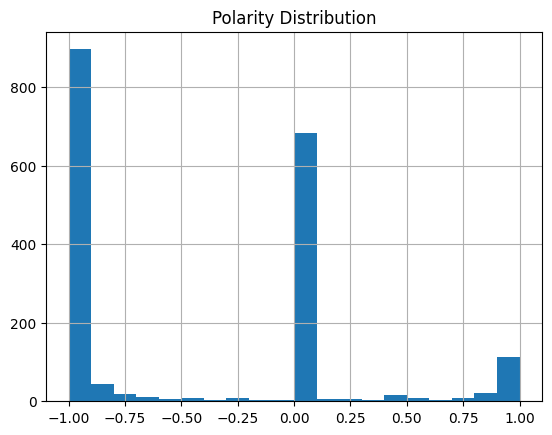

In [30]:
import matplotlib.pyplot as plt
praw_data['polarity'].hist(bins=20)
plt.title("Polarity Distribution")
plt.show()

In [31]:
polar_df=praw_data.loc[:, ["created_utc", "polarity"]]
polar_df.head()

,created_utc,polarity
0,2020-04-22,-0.989701
1,2022-10-27,0.993857
2,2024-02-24,0.083458
3,2021-01-31,-0.996130
4,2021-02-14,-0.998098


In [32]:
polar_df.rename(columns={"created_utc": "date"}, inplace=True)
polar_df.columns

Index(['date', 'polarity'], dtype='object')

In [33]:
polar_df['date'] = pd.to_datetime(polar_df['date'], format="%d/%m/%y", errors="coerce")

## Grouping the polarities based on the post date

In [35]:
# Aggregate the tweets polarization by average, sum and counts
pol_df=pd.DataFrame(polar_df.groupby('date')['polarity'].mean())
pol_df.rename(columns={"polarity": "p_mean"}, inplace=True)
pol_df['p_sum']=polar_df.groupby('date')['polarity'].sum()
pol_df['post_count']=polar_df.groupby('date')['polarity'].count()
pol_df.head()

,p_mean,p_sum,post_count
date,,,
2015-01-31,-0.978588,-0.978588,1
2015-02-28,0.000000,0.000000,1
2015-03-12,0.000000,0.000000,1
2015-03-18,0.000000,0.000000,1
2015-04-09,0.000000,0.000000,1


# Stock market forecasting

## Reading historical stock data 

In [38]:
with open("aaple_stock.csv", "r") as file:
    lines = file.readlines()

cleaned_lines = [line for line in lines if len(line.split(",")) == 6]  # Keep only rows with 6 columns

with open("cleaned_stock.csv", "w") as file:
    file.writelines(cleaned_lines)

stock_data = pd.read_csv("cleaned_stock.csv")


In [39]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11082 entries, 0 to 11081
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    11082 non-null  object 
 1   open    11082 non-null  float64
 2   high    11082 non-null  float64
 3   low     11082 non-null  float64
 4   close   11082 non-null  float64
 5   volume  11082 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 519.6+ KB


In [40]:
pol_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1015 entries, 2015-01-31 to 2024-11-26
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   p_mean      1015 non-null   float64
 1   p_sum       1015 non-null   float64
 2   post_count  1015 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 31.7 KB


In [41]:
stock_data['date']=pd.to_datetime(stock_data['date'])

In [42]:
pol_df=pol_df.reset_index()

## Merging the polarity DataFrame with the historical stock data based on date

In [44]:
final_df=pd.merge(stock_data, pol_df, on='date', how='inner')
final_df.head(10)

,date,open,high,low,close,volume,p_mean,p_sum,post_count
0,2015-03-12,27.3431,27.9221,27.1910,27.8215,193450876,0.000000,0.000000,1
1,2015-03-18,28.3915,28.8744,28.2507,28.7202,261083780,0.000000,0.000000,1
2,2015-04-09,28.1345,28.2976,27.8684,28.2932,129935896,0.000000,0.000000,1
3,2015-07-06,28.0470,28.3366,28.0268,28.2849,112241724,0.000000,0.000000,1
4,2015-07-22,27.3847,28.1727,27.3847,28.1098,461802428,0.000000,0.000000,1
5,2015-08-21,24.9017,25.2332,23.8227,23.8486,513101884,0.000000,0.000000,1
6,2015-08-24,21.3929,24.5341,20.7458,23.2533,648825168,0.000000,0.000000,1
7,2015-12-09,26.6416,26.6529,26.0618,26.1841,185445428,0.000000,0.000000,1
8,2015-12-29,24.2229,24.7823,24.2003,24.6260,123724972,-0.998364,-0.998364,1
9,2016-01-04,23.2378,23.8624,23.0996,23.8583,270597548,0.000000,0.000000,1


In [45]:
final_df.tail(20)

,date,open,high,low,close,volume,p_mean,p_sum,post_count
728,2024-10-30,232.3541,233.2131,229.2974,229.8468,45922053,0.184167,0.736669,4
729,2024-10-31,229.0877,229.5771,225.1220,225.6614,56368540,-0.001587,-0.006350,4
730,2024-11-01,220.7219,225.1020,220.0276,222.6647,63401021,-0.160664,-0.481991,3
731,2024-11-04,220.7468,222.5449,219.4683,221.7657,41757060,-0.991712,-3.966849,4
732,2024-11-05,221.5510,223.7036,220.8967,223.2041,27851162,-0.866032,-7.794291,9
733,2024-11-06,222.3651,225.8163,220.9466,222.4749,54322760,-0.681529,-2.726117,4
734,2024-11-07,224.3778,227.6243,224.3229,227.2297,41066379,-0.246451,-0.739352,3
735,2024-11-08,227.1700,228.6600,226.4050,226.9600,37914424,-0.430225,-6.023148,14
736,2024-11-11,225.0000,225.7000,221.5000,224.2300,41345521,-0.653881,-12.423738,19
737,2024-11-12,224.5500,225.5900,223.3550,224.2300,40272671,-0.837530,-14.238013,17


In [46]:
final_df.describe()

,date,open,high,low,close,volume,p_mean,p_sum,post_count
count,748,748.000000,748.000000,748.000000,748.000000,7.480000e+02,748.000000,748.000000,748.000000
mean,2022-01-01 12:11:33.048128256,140.475617,142.066328,139.048315,140.650017,9.635731e+07,-0.392492,-0.831004,1.947861
min,2015-03-12 00:00:00,21.354700,21.566400,20.745800,21.334200,2.785116e+07,-0.999569,-15.210165,1.000000
25%,2020-11-16 00:00:00,117.294700,119.385350,116.289650,117.509950,5.568703e+07,-0.979049,-0.997568,1.000000
50%,2022-04-16 12:00:00,147.389450,148.953350,145.970350,147.814050,7.990269e+07,-0.425160,-0.919581,1.000000
75%,2023-10-19 06:00:00,175.784325,178.238450,174.751600,176.506575,1.123524e+08,0.000000,0.000000,2.000000
max,2024-11-26 00:00:00,234.472000,237.228700,234.192000,236.219800,6.488252e+08,0.998824,1.968403,114.000000
std,NaN,56.377240,56.843947,55.924983,56.423788,6.434919e+07,0.541248,1.740211,4.691410


In [47]:
final_df.to_csv('Final_scraped_aapl_merged.csv', index=False)

## Importing libraries for model building, training and evaluation

In [49]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Flatten
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

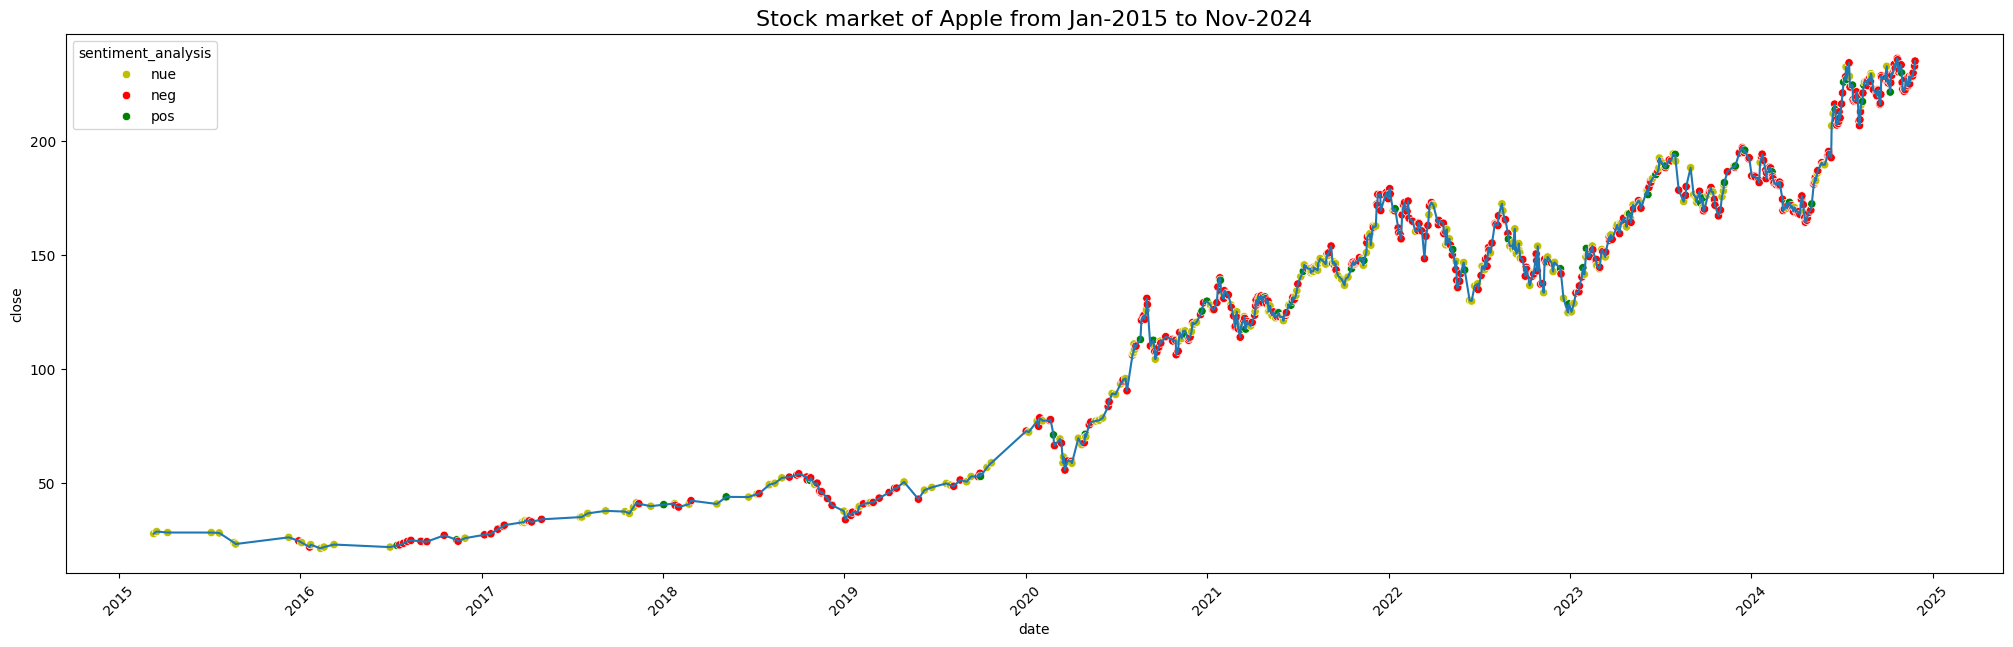

In [50]:
import seaborn as sns
plt.figure(figsize=(25,7))
sns.lineplot(x=final_df["date"], y=final_df["close"])
final_df['sentiment_analysis']=final_df['p_mean']
final_df['sentiment_analysis']=final_df['sentiment_analysis'].apply(lambda x: 'pos' if x>0 else 'nue' if x==0 else 'neg')
sns.scatterplot(x=final_df["date"],y=final_df['close'],hue=final_df['sentiment_analysis'],palette=['y','r','g'])
plt.xticks(rotation=45);
plt.title("Stock market of Apple from Jan-2015 to Nov-2024",fontsize=16);

In [51]:
final_df['sentiment_analysis'].value_counts()

sentiment_analysis
neg    438
nue    246
pos     64
Name: count, dtype: int64

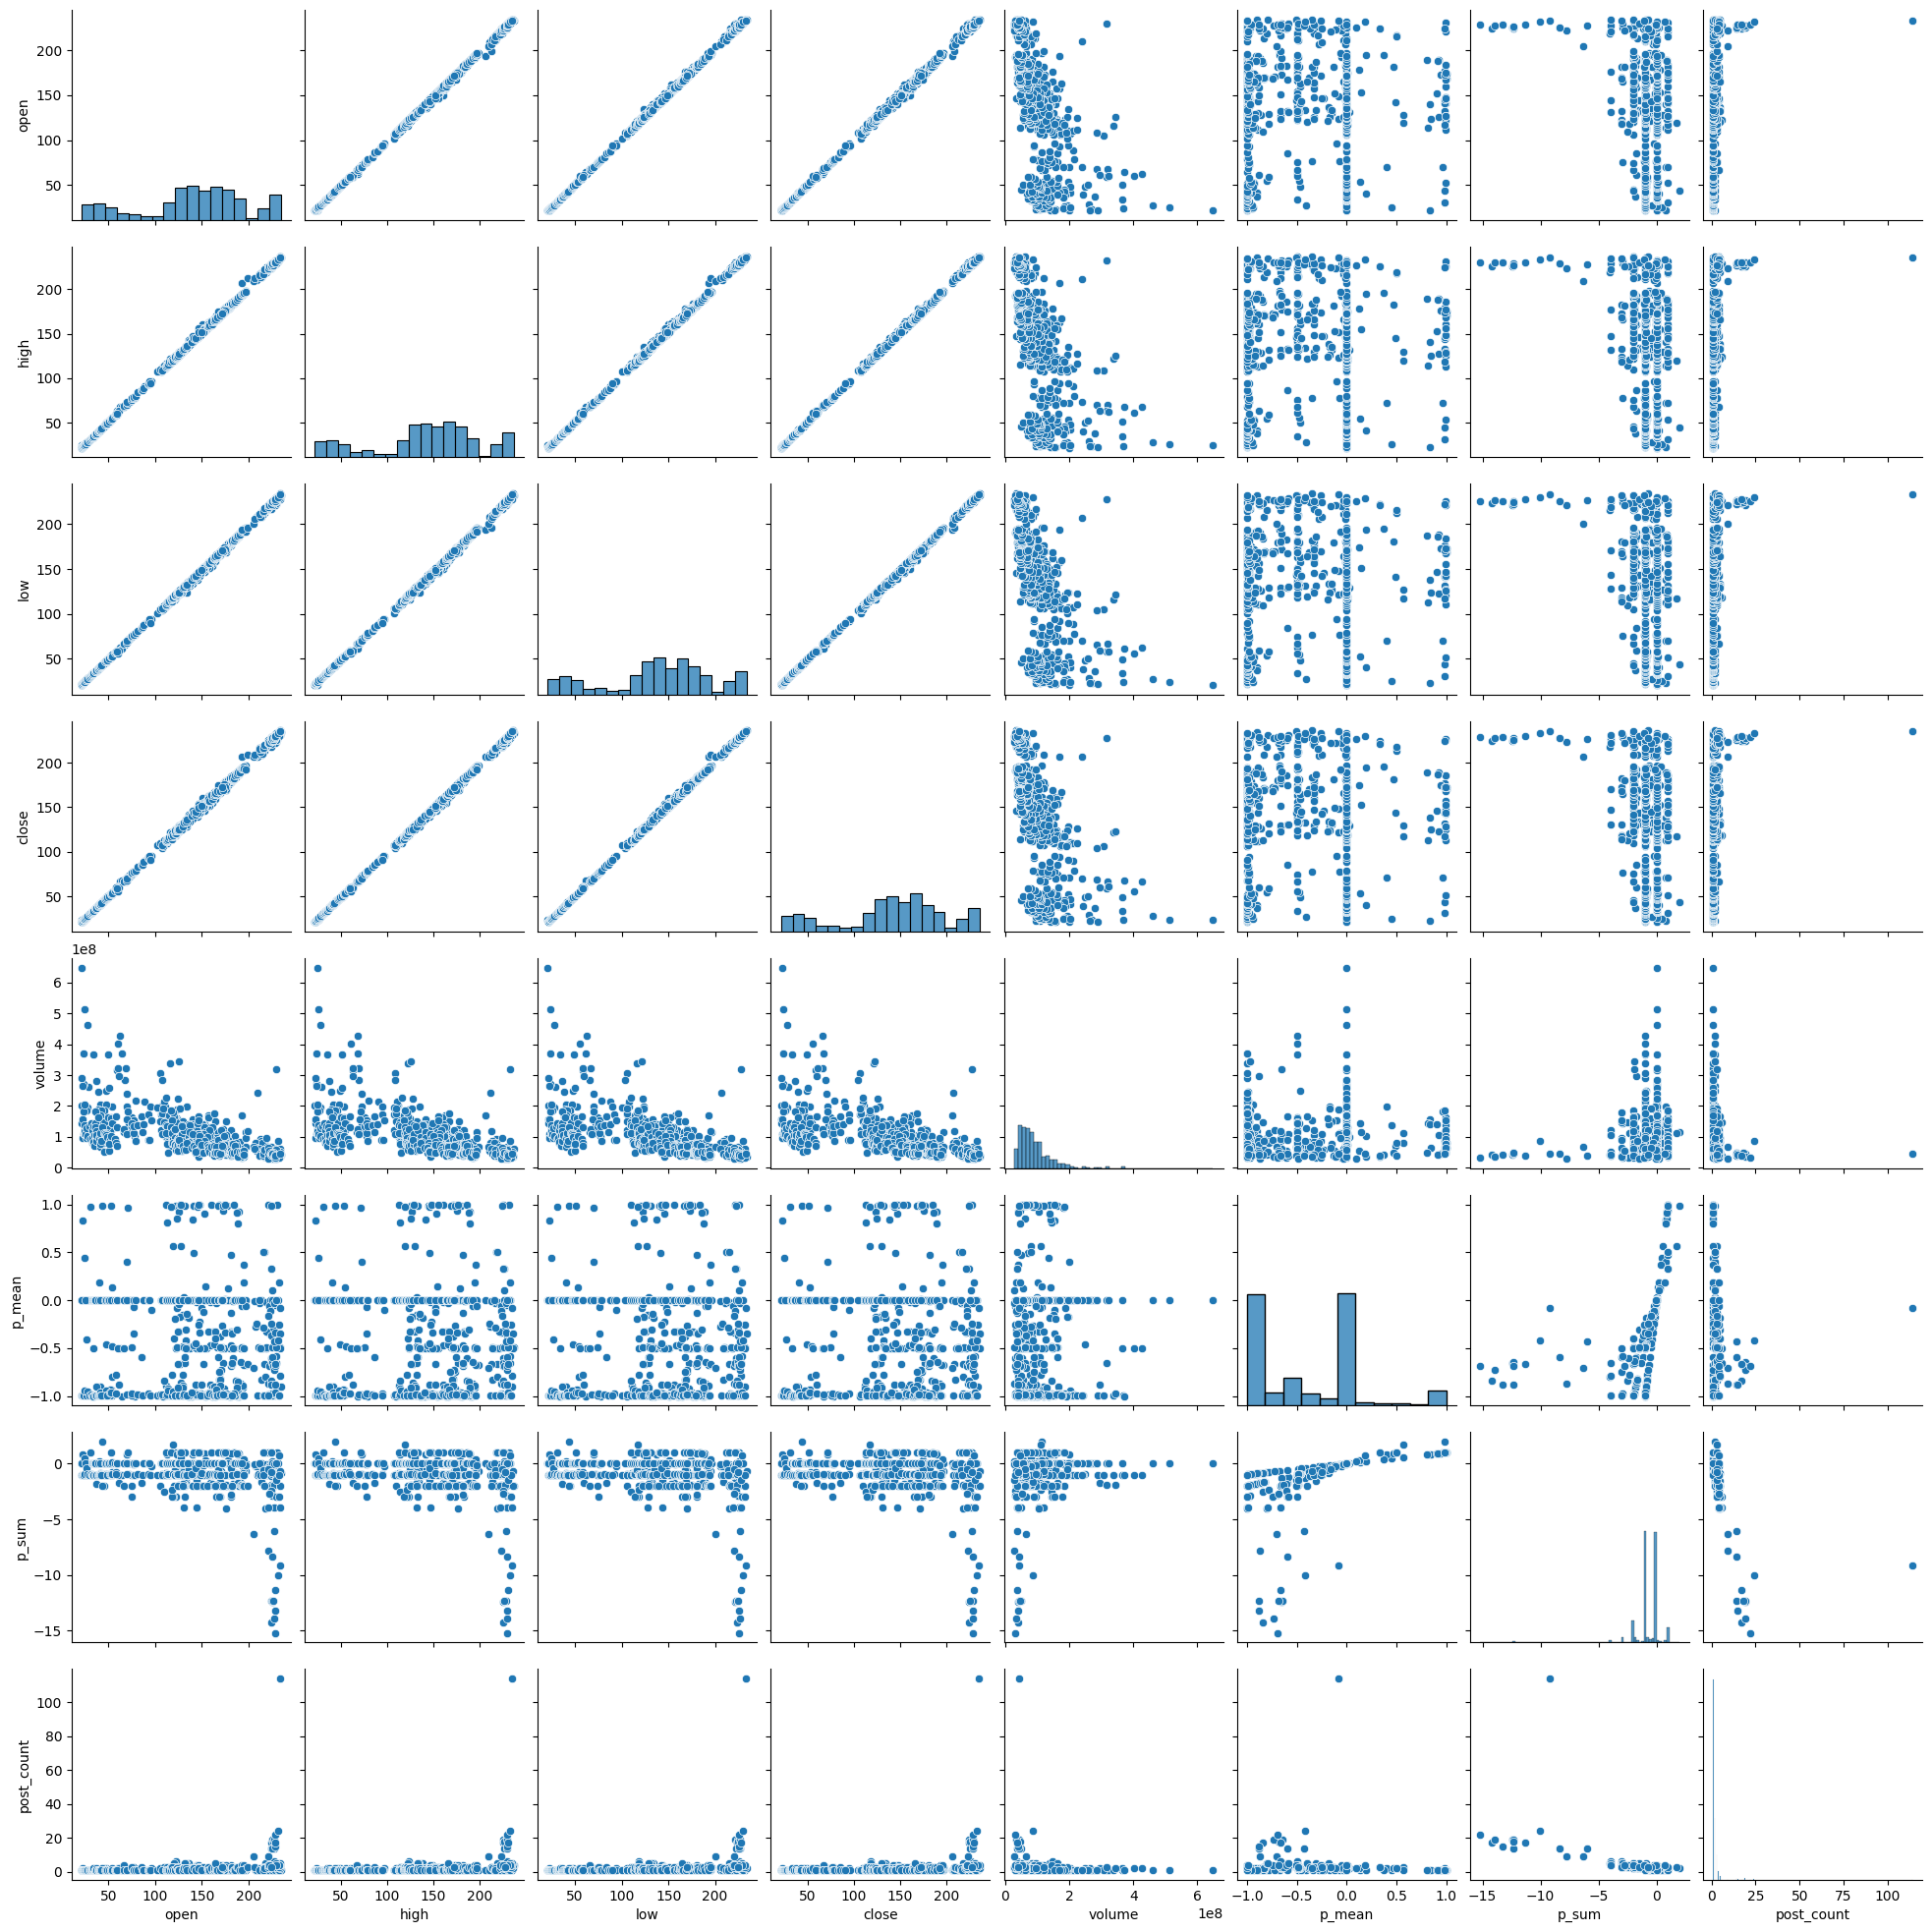

In [52]:
sns.pairplot(final_df)

In [53]:
train_dates=pd.to_datetime(final_df['date'])
print(train_dates.tail(15))

733   2024-11-06
734   2024-11-07
735   2024-11-08
736   2024-11-11
737   2024-11-12
738   2024-11-13
739   2024-11-14
740   2024-11-15
741   2024-11-18
742   2024-11-19
743   2024-11-20
744   2024-11-21
745   2024-11-22
746   2024-11-25
747   2024-11-26
Name: date, dtype: datetime64[ns]


In [54]:
final_df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'p_mean', 'p_sum',
       'post_count', 'sentiment_analysis'],
      dtype='object')

In [55]:
cols=['open',
    'high', 'low',
    'close',
    'volume',
    'p_mean'
]
print(cols)
df_for_training=final_df[cols].astype(float)
df_for_training.index=final_df['date']
df_for_training

['open', 'high', 'low', 'close', 'volume', 'p_mean']


,open,high,low,close,volume,p_mean
date,,,,,,
2015-03-12,27.3431,27.9221,27.1910,27.8215,193450876.0,0.000000
2015-03-18,28.3915,28.8744,28.2507,28.7202,261083780.0,0.000000
2015-04-09,28.1345,28.2976,27.8684,28.2932,129935896.0,0.000000
2015-07-06,28.0470,28.3366,28.0268,28.2849,112241724.0,0.000000
2015-07-22,27.3847,28.1727,27.3847,28.1098,461802428.0,0.000000
...,...,...,...,...,...,...
2024-11-20,228.0600,229.9300,225.8900,229.0000,33098494.0,-0.691371
2024-11-21,228.8800,230.1550,225.7103,228.5200,40439213.0,-0.882728
2024-11-22,228.0600,230.7199,228.0600,229.8700,38129172.0,-0.665514


## Scaling the dataset

In [57]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
scaled_training=scaler.transform(df_for_training)

In [58]:
scaler_for_inference=MinMaxScaler()
scaler_for_inference.fit_transform(df_for_training.loc[:,['open','close']])
scaled_training

array([[0.02809908, 0.02947061, 0.0301959 , 0.03018955, 0.26667737,
        0.50018652],
       [0.03301844, 0.03388631, 0.03516062, 0.03437178, 0.3755916 ,
        0.50018652],
       [0.03181253, 0.03121176, 0.03336953, 0.03238467, 0.16439454,
        0.50018652],
       ...,
       [0.96991328, 0.96981948, 0.97127145, 0.97045032, 0.01655143,
        0.16716192],
       [0.98586694, 0.98152806, 0.97914229, 0.98441124, 0.09433889,
        0.29062058],
       [0.99464145, 0.99230881, 0.99596151, 0.99460271, 0.02812434,
        0.45989439]])

## Test and train split

In [60]:
trainX=[]
trainY=[]

n_future=1
n_past=5

for i in range(n_past, len(scaled_training)-n_future+1):
    trainX.append(scaled_training[i-n_past:i, 0:scaled_training.shape[1]])
    trainY.append(scaled_training[i+n_future-1:i+n_future,[0,-2]])

trainX, trainY=np.array(trainX), np.array(trainY)
print('TrainX shape={}'.format(trainX.shape))
print('TrainY shape={}'.format(trainY.shape))

TrainX shape=(743, 5, 6)
TrainY shape=(743, 1, 2)


In [61]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_reddit, X_test_lstm_without_reddit, y_train_lstm_without_reddit, y_test_lstm_without_reddit = train_test_split(trainX[:,:,:-1], trainY, test_size=0.2, shuffle=False)

X_train_lstm_reddit, X_test_lstm_reddit, y_train_lstm_reddit, y_test_lstm_reddit = train_test_split(trainX, trainY, test_size=0.2, shuffle=False)

X_train_lstm_without_reddit.shape, X_train_lstm_reddit.shape

((594, 5, 5), (594, 5, 6))

In [62]:
from sklearn.model_selection import train_test_split

X_train_lstm_without_reddit, X_val_lstm_without_reddit, y_train_lstm_without_reddit, y_val_lstm_without_reddit = train_test_split(X_train_lstm_without_reddit, y_train_lstm_without_reddit, test_size=0.1, shuffle=False)

X_train_lstm_reddit, X_val_lstm_reddit, y_train_lstm_reddit, y_val_lstm_reddit = train_test_split(X_train_lstm_reddit, y_train_lstm_reddit, test_size=0.1, shuffle=False)

X_train_lstm_without_reddit.shape,X_train_lstm_reddit.shape

((534, 5, 5), (534, 5, 6))

## Building the CNN-LSTM Model

In [64]:
# Model architecture
seed=42
def build_model(input_shape):
    tf.random.set_seed(seed)
    cnn_lstm_model=Sequential()

    cnn_lstm_model.add(Conv1D(filters=128, kernel_size=2, strides=1, padding='valid', input_shape=input_shape))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2))

    cnn_lstm_model.add(Conv1D(filters=64, kernel_size=2, strides=2, padding='valid'))
    cnn_lstm_model.add(MaxPooling1D(pool_size=1, strides=2))

    cnn_lstm_model.add(Bidirectional(LSTM(128, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))
    cnn_lstm_model.add(Bidirectional(LSTM(128, return_sequences=True)))
    cnn_lstm_model.add(Dropout(0.2))

    cnn_lstm_model.add(Dense(32, activation='relu'))
    cnn_lstm_model.add(Dense(trainY.shape[2], activation='relu'))

    cnn_lstm_model.compile(optimizer='adam', loss='mse')
    cnn_lstm_model.summary()
    return cnn_lstm_model

In [65]:
# Fit model
cnn_lstm_model_without_reddit=build_model((X_train_lstm_without_reddit.shape[1],X_train_lstm_without_reddit.shape[2]))
cnn_lstm_model_reddit=build_model((X_train_lstm_reddit.shape[1],X_train_lstm_reddit.shape[2]))

history_without_reddit = cnn_lstm_model_without_reddit.fit(X_train_lstm_without_reddit, y_train_lstm_without_reddit, epochs=50, batch_size=64, validation_data=(X_val_lstm_without_reddit, y_val_lstm_without_reddit), verbose=1, )


history_reddit = cnn_lstm_model_reddit.fit(X_train_lstm_reddit, y_train_lstm_reddit, epochs=50, batch_size=64, validation_data=(X_val_lstm_reddit, y_val_lstm_reddit), verbose=1, )

C:\Users\KIIT\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 4, 128)              │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1, 64)               │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1, 256)              │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 1, 256)              │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1, 32)               │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1, 2)                │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 618,018 (2.36 MB)

 Trainable params: 618,018 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 4, 128)              │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 1, 64)               │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 1, 256)              │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 1, 256)              │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1, 32)               │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1, 2)                │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 618,274 (2.36 MB)

 Trainable params: 618,274 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 407ms/step - loss: 0.0914 - val_loss: 0.0241
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0227 - val_loss: 0.0190
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0120 - val_loss: 0.0046
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0090 - val_loss: 0.0029
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0073 - val_loss: 0.0045
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0061 - val_loss: 6.9686e-04
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0048 - val_loss: 8.0364e-04
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0045 - val_loss: 7.1023e-04
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0045 - val_loss: 6.8307e-04
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0043 - val_loss: 8.0481e-04
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0042 - val_loss: 6.7046e-04
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0

## Plotting Training and Validation loss without Reddit sentiment analysis

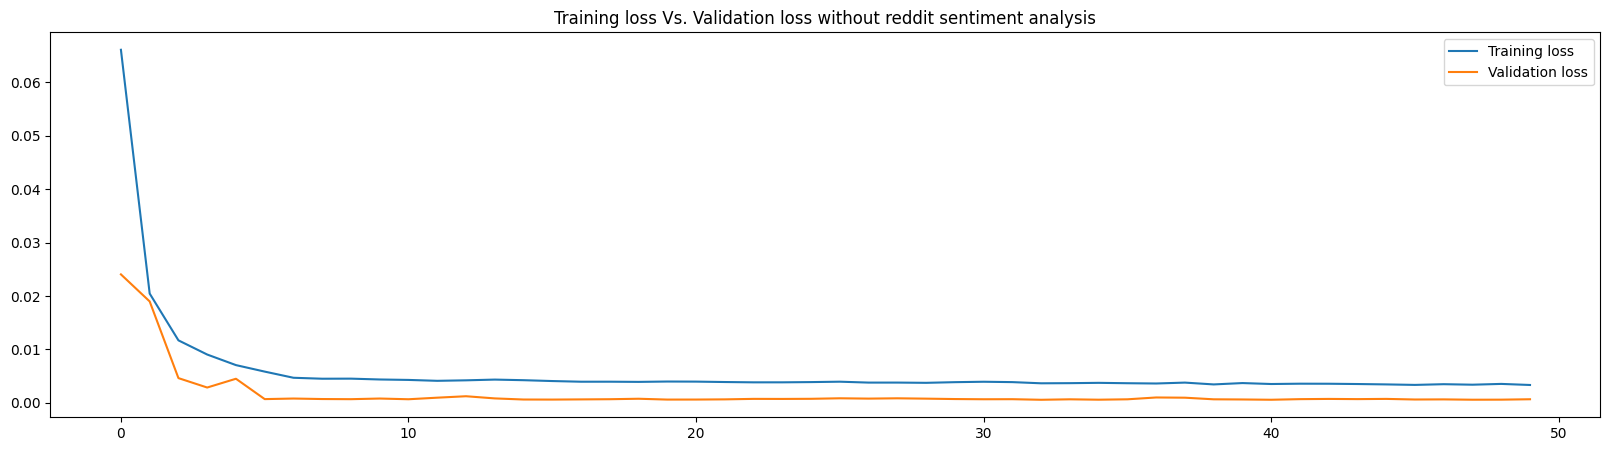

In [67]:
plt.figure(figsize=(20,5))
plt.plot(history_without_reddit.history['loss'], label='Training loss')
plt.plot(history_without_reddit.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss without reddit sentiment analysis')
plt.legend()

## Plotting Training and Validation loss including Reddit sentiment analysis¶

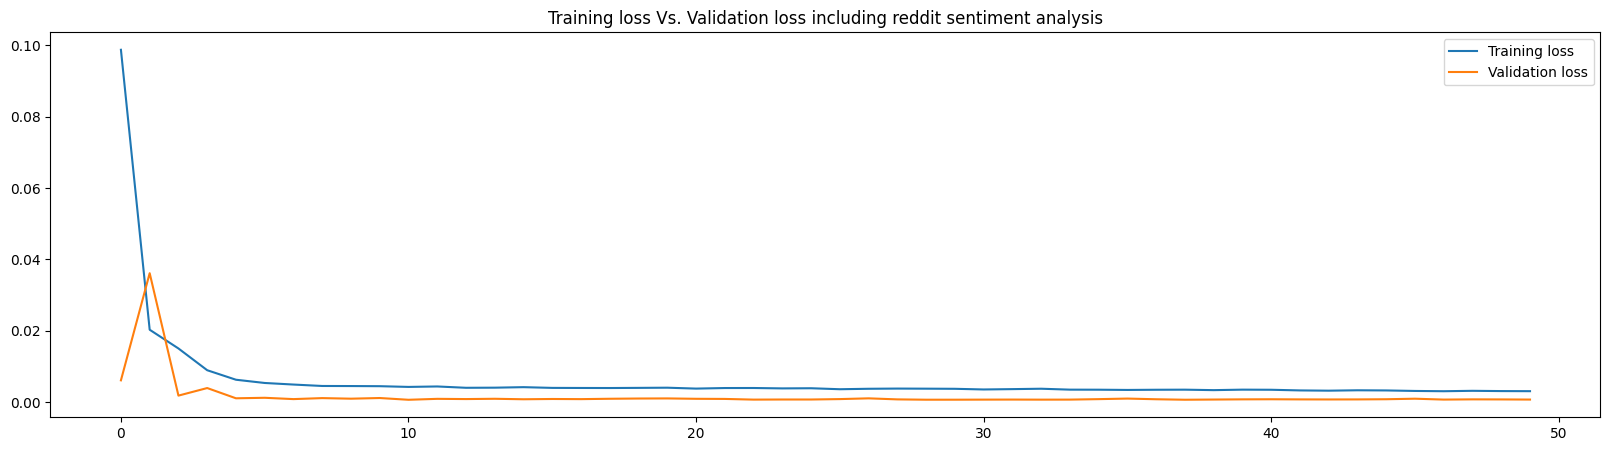

In [69]:
plt.figure(figsize=(20,5))
plt.plot(history_reddit.history['loss'], label='Training loss')
plt.plot(history_reddit.history['val_loss'], label='Validation loss')
plt.title('Training loss Vs. Validation loss including reddit sentiment analysis')
plt.legend()

In [70]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

def plot_predictions_with_dates (type,reddit,dates,y_actual_lstm,y_pred_lstm):
    predicted_features=['open','close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if reddit :
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature After adding reddit sentiment analysis')
        else:
            plt.title(f'LSTM {type} prediction of {predicted_feature} feature without reddit sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_lstm[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_lstm[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_lstm[:,i], y_pred_lstm[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

## Evaluating training data

In [72]:
training_dates= df_for_training.index[:X_train_lstm_without_reddit.shape[0]]
#Make prediction
training_prediction_without_reddit = cnn_lstm_model_without_reddit.predict(X_train_lstm_without_reddit)

training_prediction_reddit = cnn_lstm_model_reddit.predict(X_train_lstm_reddit)

training_prediction_without_reddit=training_prediction_without_reddit.reshape(training_prediction_without_reddit.shape[0], training_prediction_without_reddit.shape[2])

training_prediction_reddit=training_prediction_reddit.reshape(training_prediction_reddit.shape[0], training_prediction_reddit.shape[2])

y_train_pred_lstm_without_reddit = scaler_for_inference.inverse_transform(training_prediction_without_reddit)

y_train_pred_lstm_reddit = scaler_for_inference.inverse_transform(training_prediction_reddit)

y_train_lstm_reshaped_without_reddit=y_train_lstm_without_reddit.reshape(y_train_lstm_without_reddit.shape[0], y_train_lstm_without_reddit.shape[2])

y_train_actual_lstm = scaler_for_inference.inverse_transform(y_train_lstm_reshaped_without_reddit)

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step


## Training predictions without Reddit sentiment analysis

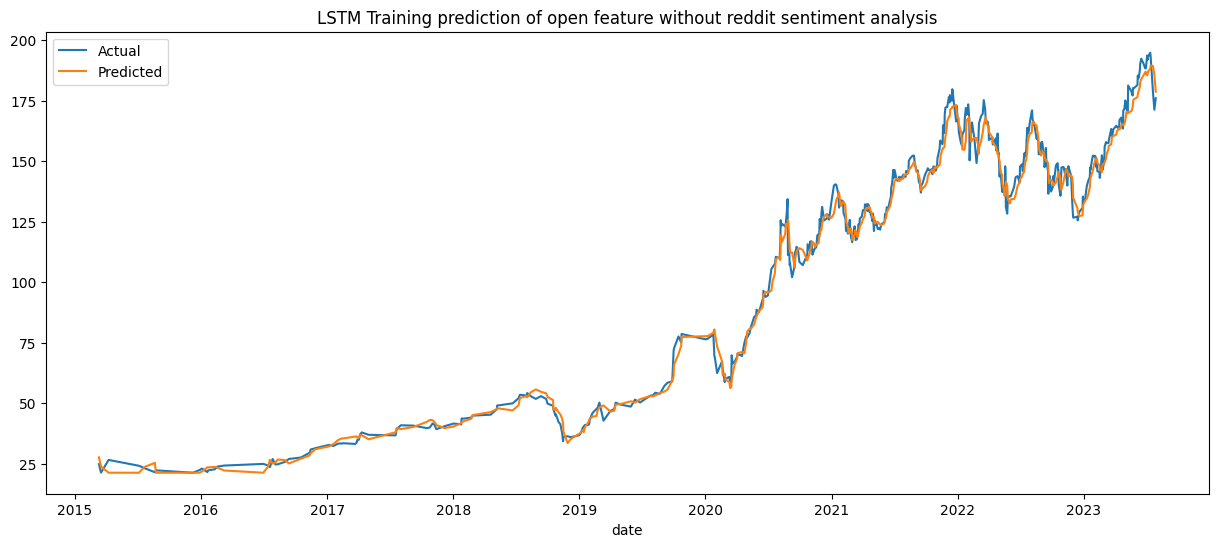

Mean square error for open =19.849654474109457


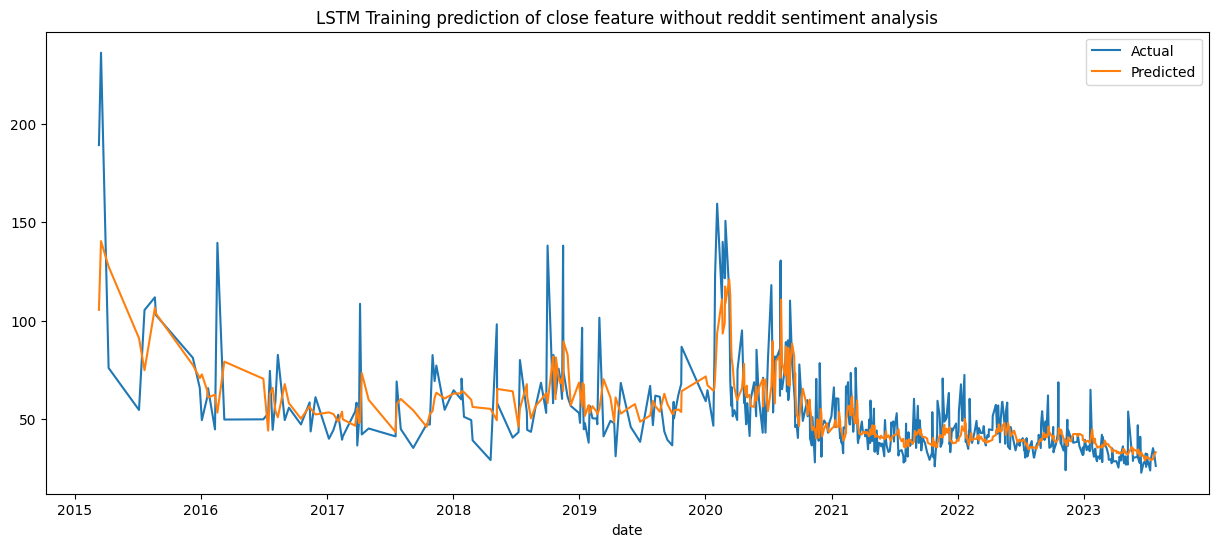

Mean square error for close =253.07074978651926
Total mean square error 136.4602021303142


In [74]:
plot_predictions_with_dates('Training',False,training_dates,y_train_actual_lstm,y_train_pred_lstm_without_reddit)

## Training prediction after Reddit sentiment analysis

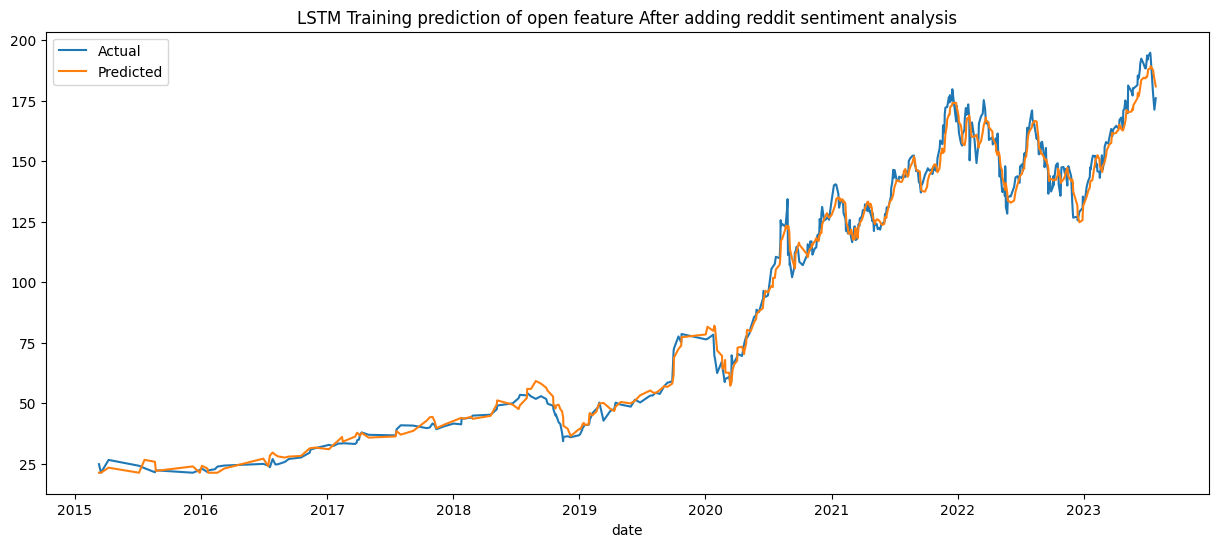

Mean square error for open =21.75404768713618


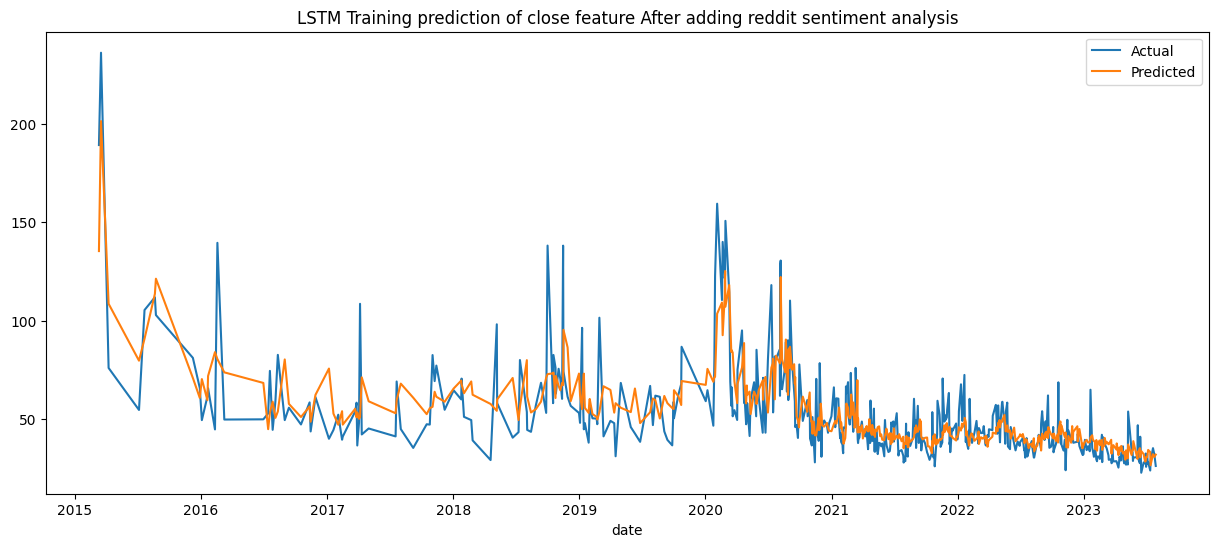

Mean square error for close =209.6374085751724
Total mean square error 115.69572813115428


In [76]:
plot_predictions_with_dates('Training',True,training_dates,y_train_actual_lstm,y_train_pred_lstm_reddit)

## Evaluating validation data

In [78]:
validation_dates= df_for_training.index[X_train_lstm_without_reddit.shape[0]:X_train_lstm_without_reddit.shape[0] + X_val_lstm_without_reddit.shape[0]]
#Make prediction
validation_prediction_without_reddit = cnn_lstm_model_without_reddit.predict(X_val_lstm_without_reddit)

validation_prediction_reddit = cnn_lstm_model_reddit.predict(X_val_lstm_reddit)

validation_prediction_without_reddit=validation_prediction_without_reddit.reshape(validation_prediction_without_reddit.shape[0], validation_prediction_without_reddit.shape[2])


validation_prediction_reddit=validation_prediction_reddit.reshape(validation_prediction_reddit.shape[0], validation_prediction_reddit.shape[2])


y_val_pred_lstm_without_reddit = scaler_for_inference.inverse_transform(validation_prediction_without_reddit)
y_val_pred_lstm_reddit = scaler_for_inference.inverse_transform(validation_prediction_reddit)

y_val_actual_lstm_reshaped_without_reddit=y_val_lstm_without_reddit.reshape(y_val_lstm_without_reddit.shape[0], y_val_lstm_without_reddit.shape[2])

y_val_actual_lstm = scaler_for_inference.inverse_transform(y_val_actual_lstm_reshaped_without_reddit)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


## Validation prediction without Reddit sentiment analysis

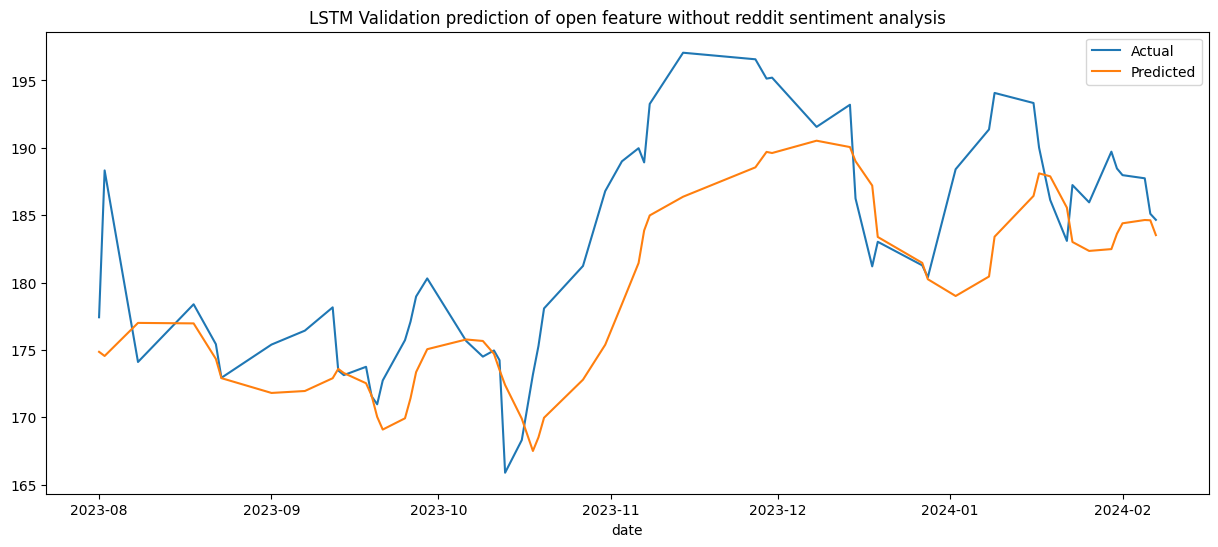

Mean square error for open =31.448091172792065


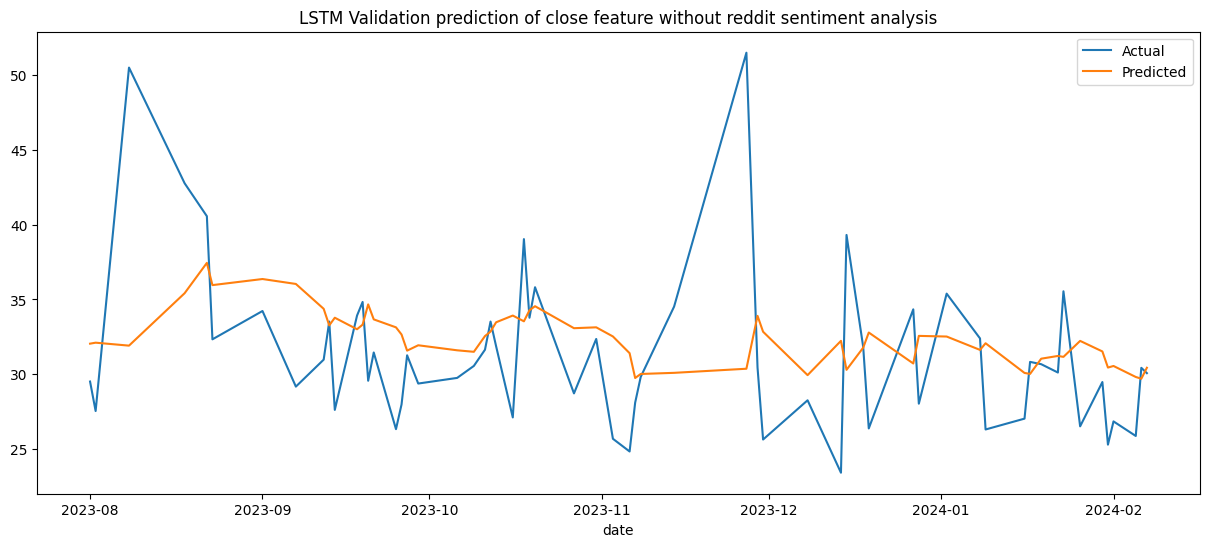

Mean square error for close =29.925642397522903
Total mean square error 30.68686678515748


In [80]:
plot_predictions_with_dates('Validation',False,validation_dates,y_val_actual_lstm,y_val_pred_lstm_without_reddit)

## Validation prediction with Reddit sentiment analysis

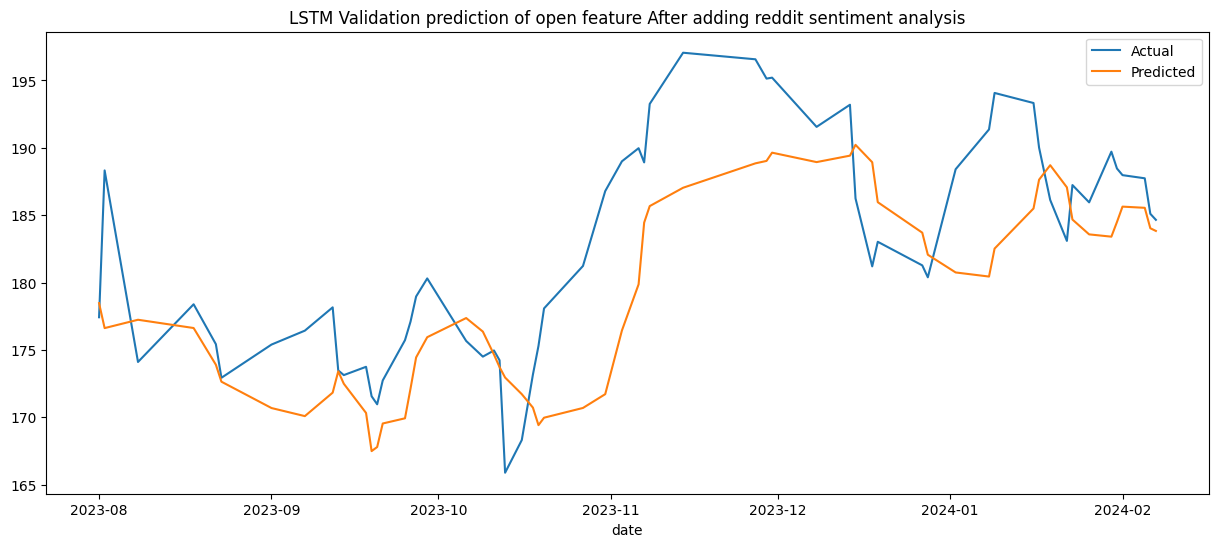

Mean square error for open =34.59689877481991


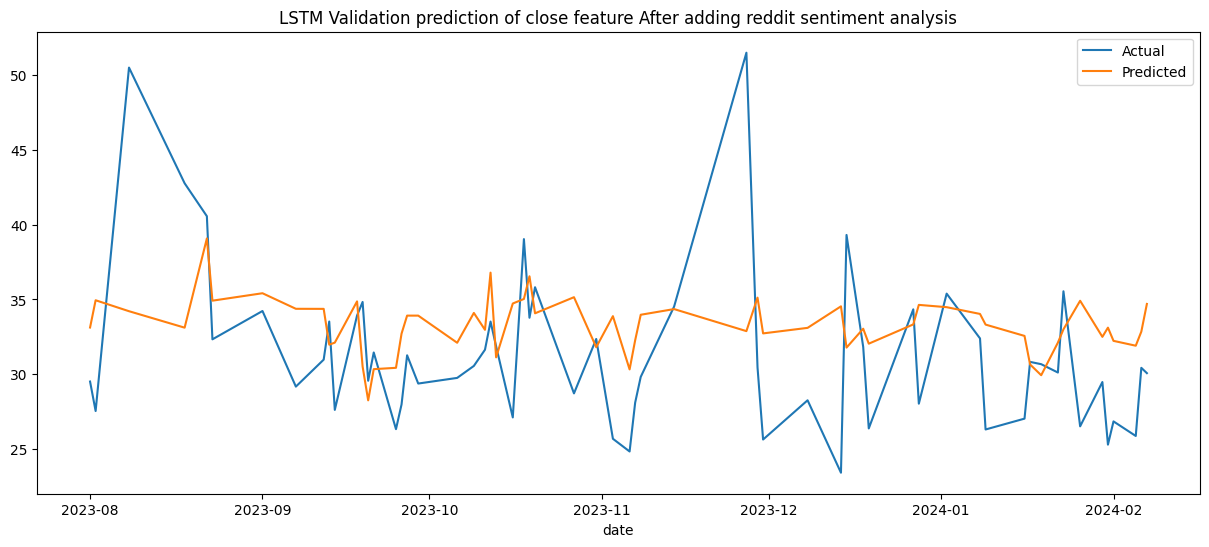

Mean square error for close =31.82929205734823
Total mean square error 33.21309541608407


In [82]:
plot_predictions_with_dates('Validation',True,validation_dates,y_val_actual_lstm,y_val_pred_lstm_reddit)

## Evaluating test data

In [84]:
testing_dates= df_for_training.index[-X_test_lstm_without_reddit.shape[0]:]
#Make prediction
testing_prediction_without_reddit = cnn_lstm_model_without_reddit.predict(X_test_lstm_without_reddit)
testing_prediction_reddit = cnn_lstm_model_reddit.predict(X_test_lstm_reddit)

testing_prediction_without_reddit=testing_prediction_without_reddit.reshape(testing_prediction_without_reddit.shape[0], testing_prediction_without_reddit.shape[2])
testing_prediction_reddit=testing_prediction_reddit.reshape(testing_prediction_reddit.shape[0], testing_prediction_reddit.shape[2])

y_test_pred_lstm_without_reddit = scaler_for_inference.inverse_transform(testing_prediction_without_reddit)
y_test_pred_lstm_reddit = scaler_for_inference.inverse_transform(testing_prediction_reddit)

y_test_actual_lstm_reshaped_without_reddit=y_test_lstm_without_reddit.reshape(y_test_lstm_without_reddit.shape[0], y_test_lstm_without_reddit.shape[2])


y_test_actual_lstm = scaler_for_inference.inverse_transform(y_test_actual_lstm_reshaped_without_reddit)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


## Test data prediction without Reddit sentiment analysis

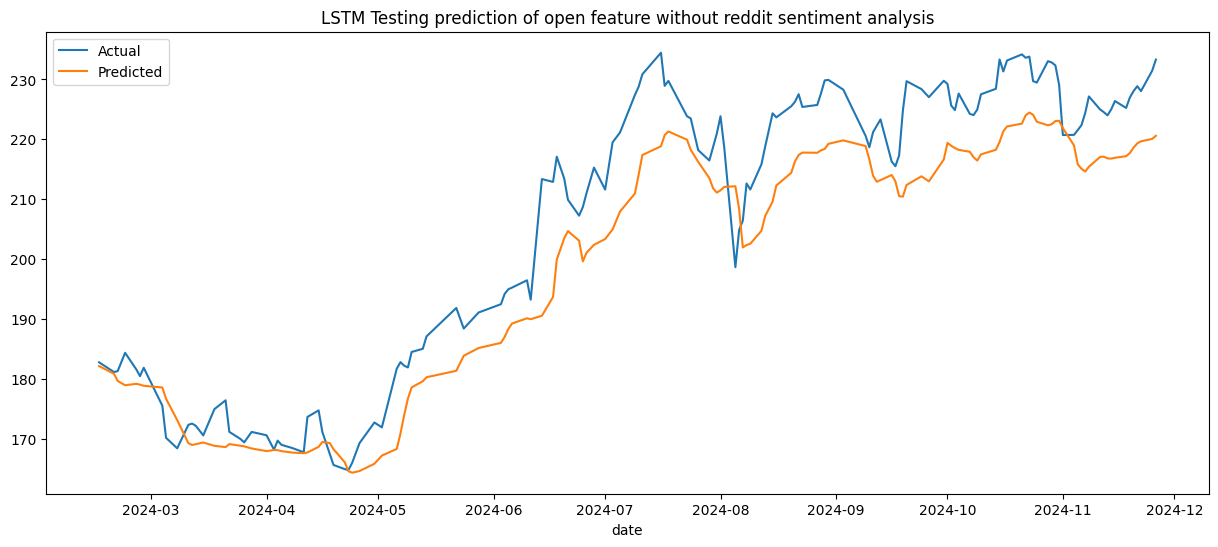

Mean square error for open =76.14288070601611


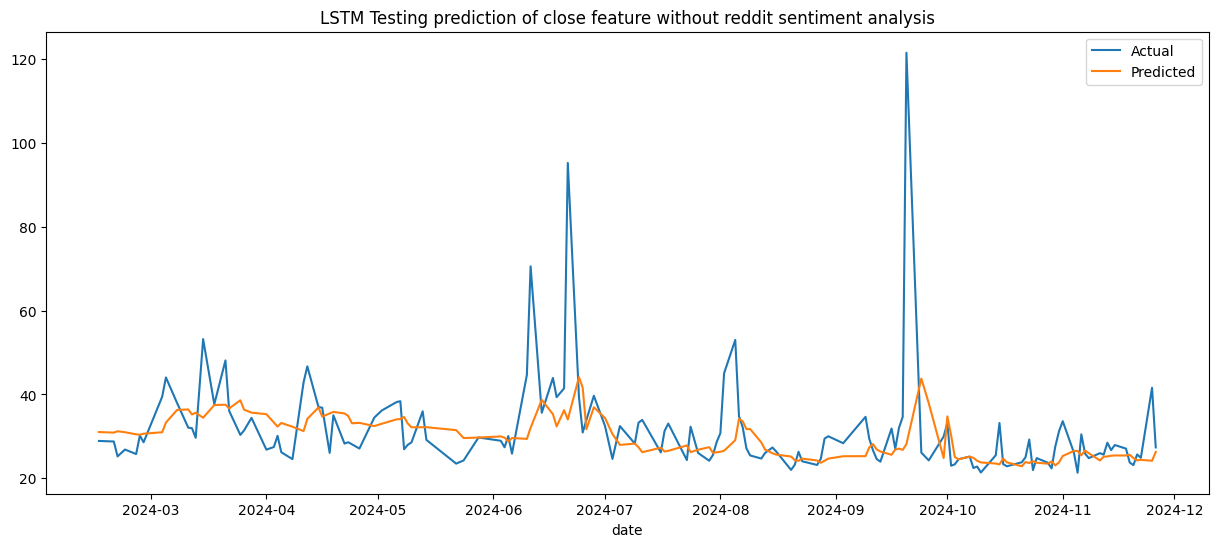

Mean square error for close =129.79698176917015
Total mean square error 102.96993123759306


In [86]:
plot_predictions_with_dates('Testing',False,testing_dates,y_test_actual_lstm,y_test_pred_lstm_without_reddit)

## Test data prediction with Reddit sentiment analysis

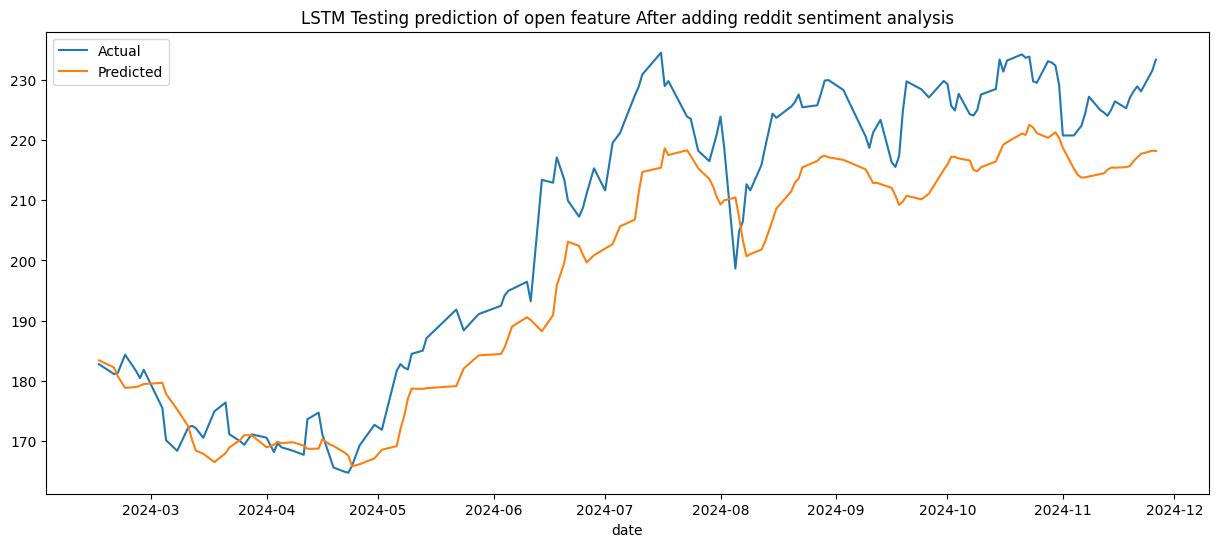

Mean square error for open =105.04879725816116


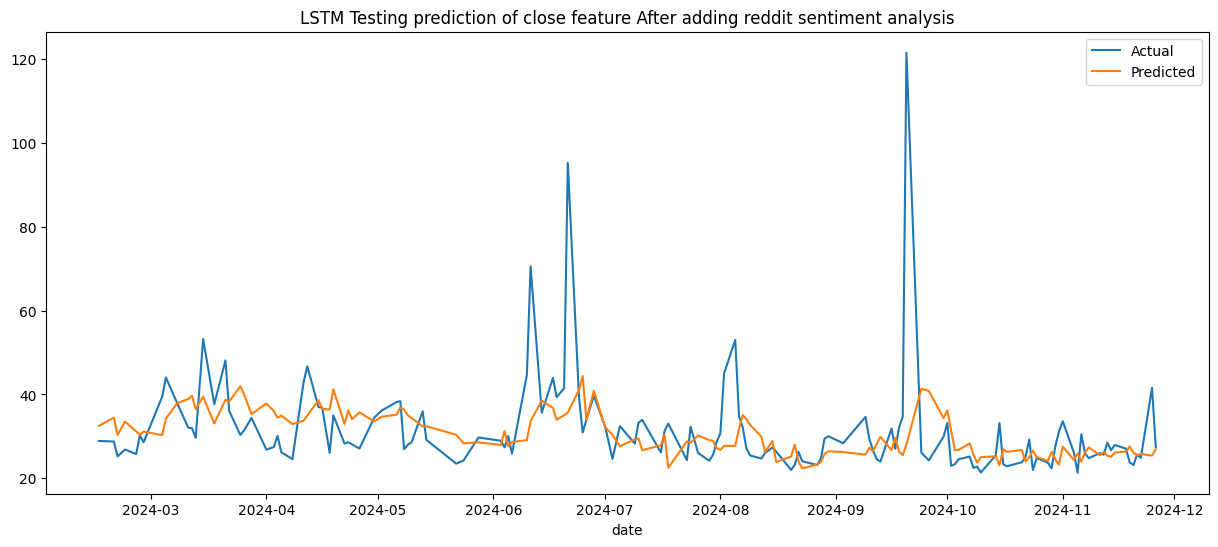

Mean square error for close =131.23469294880658
Total mean square error 118.14174510348388


In [88]:
plot_predictions_with_dates('Testing',True,testing_dates,y_test_actual_lstm,y_test_pred_lstm_reddit)